Visualize the Duke breast cancer data

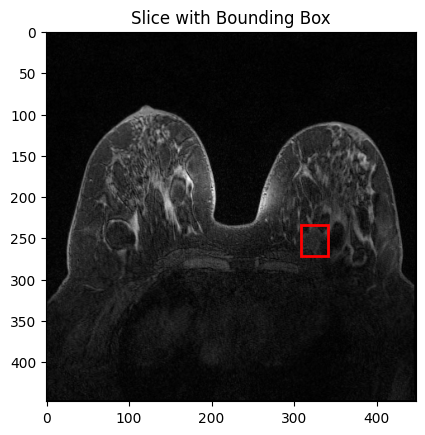

In [1]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os

def load_dicom_slices(dicom_dir):
    """
    Load DICOM slices from a directory.

    Parameters:
    - dicom_dir: directory containing DICOM files

    Returns:
    - dicom_slices: a sorted list of DICOM datasets representing slices
    """
    dicom_slices = []
    
    # Read all DICOM files in the directory
    for filename in os.listdir(dicom_dir):
        filepath = os.path.join(dicom_dir, filename)
        if os.path.isfile(filepath):
            dicom_slices.append(pydicom.dcmread(filepath))
    
    # Sort slices by the slice location
    dicom_slices.sort(key=lambda x: int(x.InstanceNumber))  # Sort by instance number (slice order)
    
    return dicom_slices

def draw_bounding_box_on_slice(slice_data, start_row, end_row, start_column, end_column):
    """
    Draws a bounding box on a single MRI slice.
    
    Parameters:
    - slice_data: 2D numpy array representing the image/slice data
    - start_row: the row where the bounding box starts
    - end_row: the row where the bounding box ends
    - start_column: the column where the bounding box starts
    - end_column: the column where the bounding box ends
    
    Returns:
    - None. Displays the slice with the bounding box.
    """
    
    # Plot the image/slice
    plt.imshow(slice_data, cmap='gray')

    # Plot the bounding box
    rect = plt.Rectangle((start_column, start_row), 
                         end_column - start_column, 
                         end_row - start_row, 
                         linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the rectangle (bounding box) to the plot
    plt.gca().add_patch(rect)

    # Show the image with the bounding box
    plt.title(f'Slice with Bounding Box')
    plt.show()

def extract_slice_with_bounding_box(dicom_slices, start_slice, end_slice, start_row, end_row, start_column, end_column):
    """
    Extracts a DICOM slice within the given slice range and draws a bounding box.

    Parameters:
    - dicom_slices: list of DICOM slice datasets
    - start_slice: the first slice index to look for the bounding box
    - end_slice: the last slice index to look for the bounding box
    - start_row, end_row, start_column, end_column: bounding box coordinates
    """
    # index at half of dicom_slices
    half = start_slice + (end_slice-start_slice) // 2
    if start_slice <= half <= end_slice:
        # Extract the pixel data
        pixel_array = dicom_slices[half].pixel_array
        # Normalize the pixel array if needed (depends on the image format)
        pixel_array = pixel_array.astype(float)
        pixel_array = (np.maximum(pixel_array, 0) / pixel_array.max()) * 255.0
        pixel_array = np.uint8(pixel_array)
        
        # Draw bounding box on this slice
        draw_bounding_box_on_slice(pixel_array, start_row, end_row, start_column, end_column)
        return
    
dicom_dir = './Duke Breast MRI/Breast_MRI_001/01-01-1990-NA-MRI BREAST BILATERAL WWO-97538/3.000000-ax dyn pre-93877' 
dicom_slices = load_dicom_slices(dicom_dir)

# Bounding box and slice parameters from your table (adjust as necessary)
patient_id = "Breast_MRI_001"
start_row = 234
end_row = 271
start_column = 308
end_column = 341
start_slice = 89
end_slice = 112

# Extract slices and draw bounding box
extract_slice_with_bounding_box(dicom_slices, start_slice, end_slice, start_row, end_row, start_column, end_column)


Visualize the UCFS-PDGM data

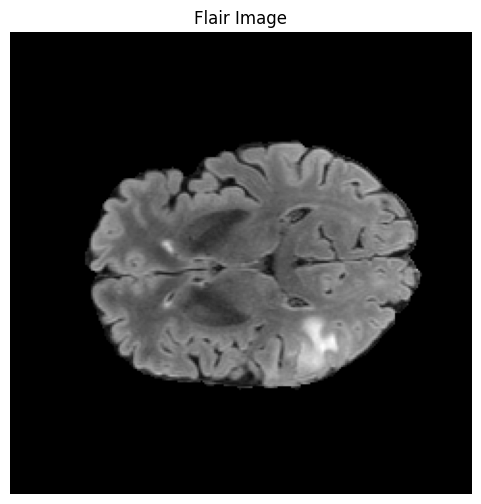

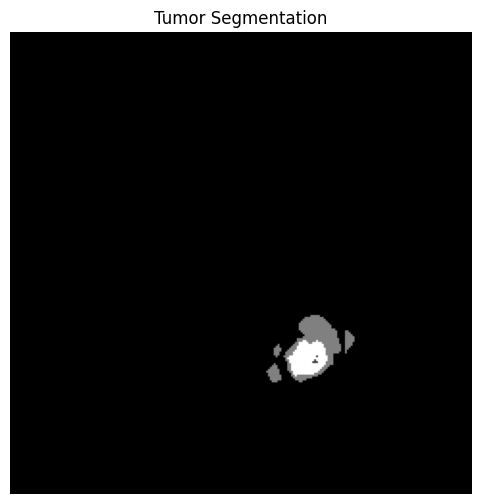

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import gzip

def load_nifti_gz(file_path):
    """
    Load a NIfTI file compressed with gzip (.nii.gz).
    
    Parameters:
    - file_path: Path to the .nii.gz file
    
    Returns:
    - image_data: The image data as a numpy array
    """
    # Load the NIfTI file using nibabel
    img = nib.load(file_path)
    image_data = img.get_fdata()
    return image_data

def display_slice(image_data, slice_index, title=""):
    """
    Display a single slice of the image data.
    
    Parameters:
    - image_data: The 3D numpy array of image data
    - slice_index: The index of the slice to display
    - title: Title for the image
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image_data[:, :, slice_index], cmap="gray")
    plt.title(title)
    plt.axis('off')
    plt.show()

# Define paths to your FLAIR and tumor segmentation images
flair_path = './USCF-PDGM/UCSF-PDGM-v3/UCSF-PDGM-0004_nifti/UCSF-PDGM-0004_FLAIR.nii.gz'
segmentation_path = './USCF-PDGM/UCSF-PDGM-v3/UCSF-PDGM-0004_nifti/UCSF-PDGM-0004_tumor_segmentation.nii.gz'

# Load the images
flair_image = load_nifti_gz(flair_path)
segmentation_image = load_nifti_gz(segmentation_path)

# Display a specific slice (for example, slice number 50)
slice_index = 90  # You can change this to visualize other slices

# Display the FLAIR image
display_slice(flair_image, slice_index, title="Flair Image")

# Display the tumor segmentation image
display_slice(segmentation_image, slice_index, title="Tumor Segmentation")


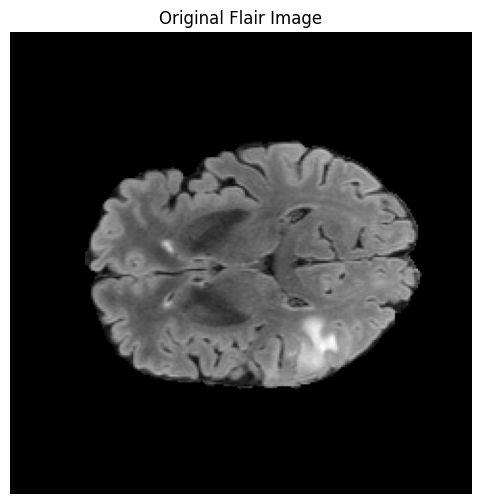

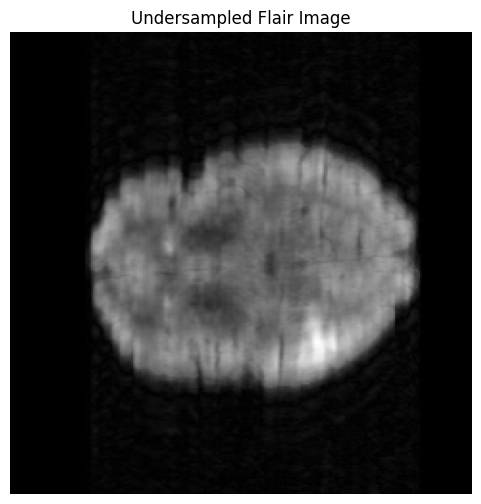

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
from fastmri import fft2c, ifft2c, tensor_to_complex_np
from fastmri.data.subsample import RandomMaskFunc

# Step 1: Load NIfTI data and convert it to a PyTorch tensor

def load_nifti_gz_as_tensor(file_path):
    """
    Load a NIfTI file compressed with gzip (.nii.gz) and convert to a PyTorch tensor.
    
    Parameters:
    - file_path: Path to the .nii.gz file
    
    Returns:
    - image_tensor: The image data as a PyTorch tensor
    """
    img = nib.load(file_path)
    image_data = img.get_fdata()
    
    # Convert to PyTorch tensor (add channel dimension for MRI image)
    image_tensor = torch.from_numpy(image_data).unsqueeze(0).float()  # Shape: [1, H, W, D]
    
    return image_tensor

# Step 2: Convert real-valued image to complex format

def convert_to_complex(image_slice):
    """
    Convert a real-valued 2D image slice to complex format.
    
    Parameters:
    - image_slice: 2D real-valued image tensor
    
    Returns:
    - complex_tensor: Complex-valued tensor with shape [H, W, 2] where the last dimension is (real, imaginary)
    """
    # Add a complex dimension (real part = image_slice, imaginary part = 0)
    complex_tensor = torch.stack((image_slice, torch.zeros_like(image_slice)), dim=-1)
    
    return complex_tensor

# Step 3: Apply undersampling using FastMRI

def undersample_image(image_tensor, slice_index):
    """
    Undersample an MRI image using FastMRI random mask on the k-space.
    
    Parameters:
    - image_tensor: The 3D PyTorch tensor of image data
    - slice_index: The index of the slice to undersample
    
    Returns:
    - undersampled_image: The reconstructed image after undersampling
    """
    # Extract the slice we want to process
    slice_2d = image_tensor[:, :, :, slice_index].squeeze(0)  # Shape: [H, W]

    # Convert real slice to complex-valued tensor
    complex_slice = convert_to_complex(slice_2d)

    # Perform Fourier transform to go from image space to k-space
    kspace = fft2c(complex_slice)  # Apply center Fourier transform

    # Apply random undersampling in k-space
    mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])  # 4x undersampling
    mask = mask_func(kspace.shape, seed=None)[0]  # Extract the mask
    mask = mask.to(kspace.device).unsqueeze(-1)  # Ensure mask has an extra dimension for complex part
    
    # Apply mask to k-space (zero out k-space lines)
    undersampled_kspace = kspace * mask

    # Reconstruct the undersampled image by performing the inverse Fourier transform
    undersampled_image = ifft2c(undersampled_kspace)
    
    # Convert to numpy for visualization
    undersampled_image_np = tensor_to_complex_np(undersampled_image)[0]  # Shape: [H, W]
    
    return undersampled_image_np


# Step 4: Visualization function to display MRI images

def display_mri_image(image, title=""):
    """
    Display a 2D MRI image (from numpy array).
    
    Parameters:
    - image: The 2D numpy array of image data
    - title: Title for the image
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(np.abs(image), cmap="gray")
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the images
flair_path = './USCF-PDGM/UCSF-PDGM-v3/UCSF-PDGM-0004_nifti/UCSF-PDGM-0004_FLAIR.nii.gz'
segmentation_path = './USCF-PDGM/UCSF-PDGM-v3/UCSF-PDGM-0004_nifti/UCSF-PDGM-0004_tumor_segmentation.nii.gz'

# Load FLAIR and Segmentation images as tensors
flair_image_tensor = load_nifti_gz_as_tensor(flair_path)
segmentation_image_tensor = load_nifti_gz_as_tensor(segmentation_path)

# Select a specific slice to undersample and visualize
slice_index = 90

# Apply undersampling to the selected slice of FLAIR image
undersampled_image = undersample_image(flair_image_tensor, slice_index)

# Display the original FLAIR image and the undersampled image
display_mri_image(flair_image_tensor[0, :, :, slice_index].numpy(), title="Original Flair Image")
display_mri_image(undersampled_image, title="Undersampled Flair Image")


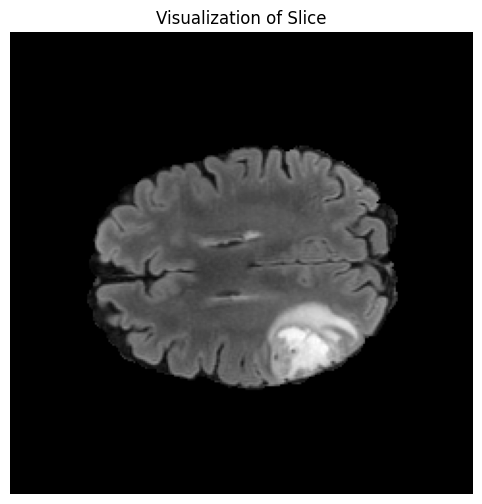

In [10]:
# Load from processed files
scan_slice = np.load("./USCF-PDGM/UCSF-PDGM-v3/processed/UCSF-PDGM-004_slice_110.npy")
plt.figure(figsize=(12, 6))
plt.imshow(scan_slice, cmap='gray')
plt.title(f'Visualization of Slice')
plt.axis('off')
plt.show()


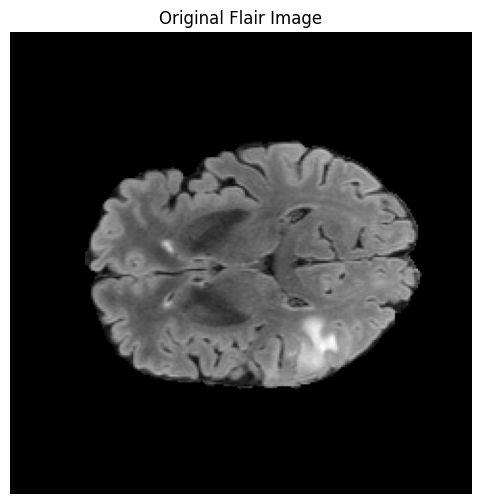

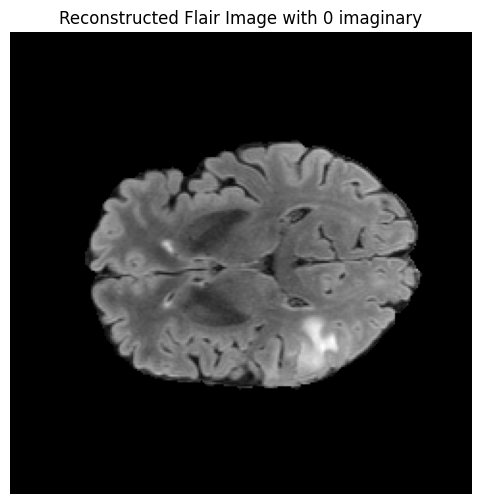

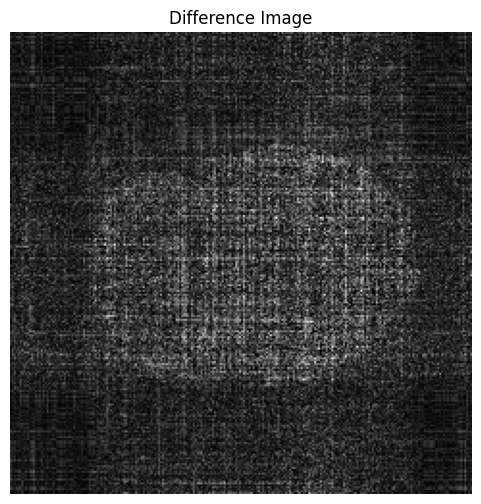

Max difference: 0.000549989752471447
Mean Squared Error: (9.806723433314346e-09-2.0559312585710643e-10j)


In [18]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
from fastmri import fft2c, ifft2c, tensor_to_complex_np
from fastmri.data.subsample import RandomMaskFunc

def load_nifti_gz_as_tensor(file_path):
    """
    Load a NIfTI file compressed with gzip (.nii.gz) and convert to a PyTorch tensor.
    
    Parameters:
    - file_path: Path to the .nii.gz file
    
    Returns:
    - image_tensor: The image data as a PyTorch tensor
    """
    img = nib.load(file_path)
    image_data = img.get_fdata()
    
    # Convert to PyTorch tensor (add channel dimension for MRI image)
    image_tensor = torch.from_numpy(image_data).unsqueeze(0).float()  # Shape: [1, H, W, D]
    
    return image_tensor

def convert_to_complex(image_slice):
    """
    Convert a real-valued 2D image slice to complex format.
    
    Parameters:
    - image_slice: 2D real-valued image tensor
    
    Returns:
    - complex_tensor: Complex-valued tensor with shape [H, W, 2] where the last dimension is (real, imaginary)
    """
    # Add a complex dimension (real part = image_slice, imaginary part = 0)
    complex_tensor = torch.stack((image_slice, torch.zeros_like(image_slice)), dim=-1)
    
    return complex_tensor

def reconstruct_image(image_tensor, slice_index):
    """
    Undersample an MRI image using FastMRI random mask on the k-space.
    
    Parameters:
    - image_tensor: The 3D PyTorch tensor of image data
    - slice_index: The index of the slice to undersample
    
    Returns:
    - undersampled_image: The reconstructed image after undersampling
    """
    # Extract the slice we want to process
    slice_2d = image_tensor[:, :, :, slice_index].squeeze(0)  # Shape: [H, W]

    # Convert real slice to complex-valued tensor
    complex_slice = convert_to_complex(slice_2d)

    # Perform Fourier transform with orthogonal normalization
    kspace = fft2c(complex_slice, norm='ortho')  # Apply centered FFT with normalization

    # Reconstruct the image by performing the inverse Fourier transform with orthogonal normalization
    reconstructed_image = ifft2c(kspace, norm='ortho')
    
    # Convert to numpy for visualization
    reconstructed_image_np = tensor_to_complex_np(reconstructed_image)  # Shape: [H, W]
    
    return reconstructed_image_np



# Step 4: Visualization function to display MRI images

def display_mri_image(image, title=""):
    """
    Display a 2D MRI image (from numpy array).
    
    Parameters:
    - image: The 2D numpy array of image data
    - title: Title for the image
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(np.abs(image), cmap="gray")
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the images
flair_path = './USCF-PDGM/UCSF-PDGM-v3/UCSF-PDGM-0004_nifti/UCSF-PDGM-0004_FLAIR.nii.gz'
segmentation_path = './USCF-PDGM/UCSF-PDGM-v3/UCSF-PDGM-0004_nifti/UCSF-PDGM-0004_tumor_segmentation.nii.gz'

# Load FLAIR and Segmentation images as tensors
flair_image_tensor = load_nifti_gz_as_tensor(flair_path)
segmentation_image_tensor = load_nifti_gz_as_tensor(segmentation_path)

# Select a specific slice to undersample and visualize
slice_index = 90

# Apply undersampling to the selected slice of FLAIR image
original_image = flair_image_tensor[0, :, :, slice_index].numpy()
reconstructed_image = reconstruct_image(flair_image_tensor, slice_index)
difference = original_image - reconstructed_image

# Display the original FLAIR image and the undersampled image
display_mri_image(original_image, title="Original Flair Image")
display_mri_image(reconstructed_image, title="Reconstructed Flair Image with 0 imaginary")
display_mri_image(difference, title="Difference Image")

max_difference = np.max(np.abs(difference))
print(f"Max difference: {max_difference}")

# Optionally, compute the mean squared error
mse = np.mean(difference ** 2)
print(f"Mean Squared Error: {mse}")

overall_max = np.max(np.abs(original_image))
overall_min = np.min(np.abs(original_image))
print(f"Overall Max: {overall_max}")
print(f"Overall Min: {overall_min}")